# satCORPS composite Sketch #2 Subsetting

- Uses starepandas branch granular_democracy


In [1]:
import pystare
import starepandas
import geopandas
import pandas

import numpy
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs

import datetime

import regionmask
import xarray
from shapely.geometry import Polygon

import dask

plot_options = {'projection': ccrs.PlateCarree(central_longitude=0.0)
                ,'transform': ccrs.Geodetic()}

In [2]:
from starepandas.io.granules import Granule

class satcorps_composite(Granule):

    def __init__(self, file_path, sidecar_path=None):
        super(satcorps_composite, self).__init__(file_path, sidecar_path)
        self.nom_res = ''
        self.companion_prefix = 'composite'
        
        self.source_nc = starepandas.io.s3.nc4_dataset_wrapper(self.file_path, 'r', format='NETCDF4')
        self.lat = None
        self.lon = None
        self.data = {}

    def read_data(self):
        if False:
            dataset_names = ['time' # "days since 1858-11-17T00:00:00.000"
                             ,'map_data/BT_10.8um']

            for dataset_name in dataset_names:
                self.data[dataset_name] = self.source_nc.select(dataset_name).get()
        
#        self.data['time'] = self.source_nc['time'][:].astype(numpy.double)

        ds_names = {
            'BT_10_8um':'BT_10.8um',
            'BT_12_0um':'BT_12.0um',
            'BT_3_75um':'BT_3.75um',
            'BT_6_75um':'BT_6.75um'
        }
        for ds_name in ds_names.keys():
            self.data[ds_name] = self.source_nc.groups['map_data'][ds_names[ds_name]][:].astype(numpy.double)
    
        lat = self.source_nc.groups['map_data']['lat'][:].astype(numpy.double); nlat=len(lat)
        lon = self.source_nc.groups['map_data']['lon'][:].astype(numpy.double); nlon=len(lon)
        self.data['lats'] = numpy.ascontiguousarray(numpy.tile(lat,(nlon,1)).transpose())
        self.data['lons'] = numpy.tile(lon,(nlat,1))

starepandas.io.granules.granule_factory_library['composite']=satcorps_composite

starepandas.io.granules.granule_factory_library

{'MOD05|MYD05': starepandas.io.granules.modis.Mod05,
 'MOD09|MYD09': starepandas.io.granules.modis.Mod09,
 'VNP02DNB|VJ102DNB': starepandas.io.granules.viirsl2.VNP02DNB,
 'VNP03DNB|VJ103DNB': starepandas.io.granules.viirsl2.VNP03DNB,
 'VNP03MOD|VJ103MOD': starepandas.io.granules.viirsl2.VNP03MOD,
 'CLDMSKL2VIIRS': starepandas.io.granules.viirsl2.CLDMSKL2VIIRS,
 'SSMIS': starepandas.io.granules.ssmis.SSMIS,
 'ATMS': starepandas.io.granules.atms.ATMS,
 'composite': __main__.satcorps_composite}

!wget https://www2.census.gov/geo/tiger/TIGER2019/STATE/tl_2019_us_state.zip

In [3]:
start0 = datetime.datetime.now()

In [4]:
# Get some locales
if True:
    states = geopandas.read_file('tl_2019_us_state.zip')
    states = starepandas.STAREDataFrame(states)
    sids = states.make_sids(n_workers=50, resolution=10)
    states.set_sids(sids, inplace=True)
    trixels = states.make_trixels(n_workers=50, wrap_lon=False)
    states.set_trixels(trixels, inplace=True)
    states.split_antimeridian(inplace=True)

In [5]:
if True:
    # roi=states[states.NAME=='Hawaii']
    # roi=states[states.NAME=='California']
    conus = states[~states['NAME'].isin(['Alaska'
                                         ,'Hawaii'
                                         ,'United States Virgin Islands'
                                         ,'Commonwealth of the Northern Mariana Islands'
                                         ,'Guam'
                                         ,'American Samoa'
                                         ,'Puerto Rico'])]
    # roi = conus
    
    conus1 = starepandas.STAREDataFrame(conus.dissolve())
    
    # Set resolution
    conus1.set_sids(conus1.make_sids(resolution=5),inplace=True)
    conus1.set_trixels(conus1.make_trixels(),inplace=True)
    
    roi = starepandas.STAREDataFrame(sids=conus1.stare_dissolve(n_workers=50,aggfunc='first'))
    roi.set_trixels(roi.make_trixels(),inplace=True)

if False:
    roi.to_hdf('conus-roi.h5','stare_indexed')

In [6]:
print('time to read roi data and make roi stare index: ',datetime.datetime.now() - start0)

time to read roi data and make roi stare index:  0:01:52.005608


In [7]:
# starepandas.STAREDataFrame(conus1)

In [8]:
# Get some locales
if False:
    world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
    world.sort_values(by='name', inplace=True)
    world = starepandas.STAREDataFrame(world)
    
    if False:
        world.plot(trixels=False)
        
if False:
    roi = world[world.name=='United States of America']
    # roi = world[world.name=='Bahamas']
    # roi = world[world.name=='Vanuatu']
    # roi = world[world.name=='Iceland']
    roi.set_sids(roi.make_sids(resolution=7),inplace=True)
    roi.set_trixels(roi.make_trixels(),inplace=True)

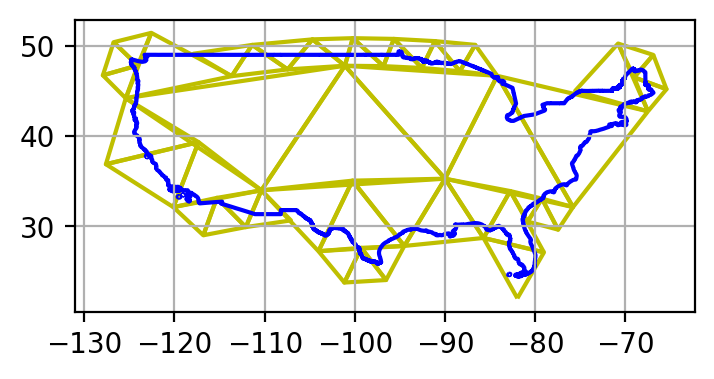

In [9]:
# Show the ROI in STARE
if True:
    fig, ax = plt.subplots(figsize=(4,4), dpi=200)
    ax.grid(True)


    roi.plot(ax=ax, trixels=True, boundary=True, color='y', zorder=1)
    conus1.plot(ax=ax, trixels=False, facecolor="none", edgecolor='blue', zorder=1)

    del fig,ax

In [10]:
start0 = datetime.datetime.now()

In [11]:
# Load the granule
if True:
    granule_name = 'ignored/satCORPS/composite_20220420_2019.182.0230.nc'
    composite = starepandas.read_granule(granule_name
                                         ,sidecar=True
                                         ,sidecar_path='ignored/satCORPS/satCORPS_composite_stare.nc')
    print('time to read granule with stare sidecar: ',datetime.datetime.now() - start0)

time to read granule with stare sidecar:  0:00:33.113585


In [12]:
# a = composite.stare_intersects(roi['sids'].iloc[0],n_workers=50)
a = composite.stare_intersects(roi['sids'].iloc[:].to_numpy(),n_workers=36)
print('time to read granule and calculate intersection',datetime.datetime.now() - start0)

time to read granule and calculate intersection 0:01:03.295974


In [13]:
composite_subset = composite[a]

In [14]:
print('time to read granule, calculate intersection, and subset the data',datetime.datetime.now() - start0)

time to read granule, calculate intersection, and subset the data 0:01:03.444858


In [15]:
start0 = datetime.datetime.now()

time to start plot:  0:00:00.283005


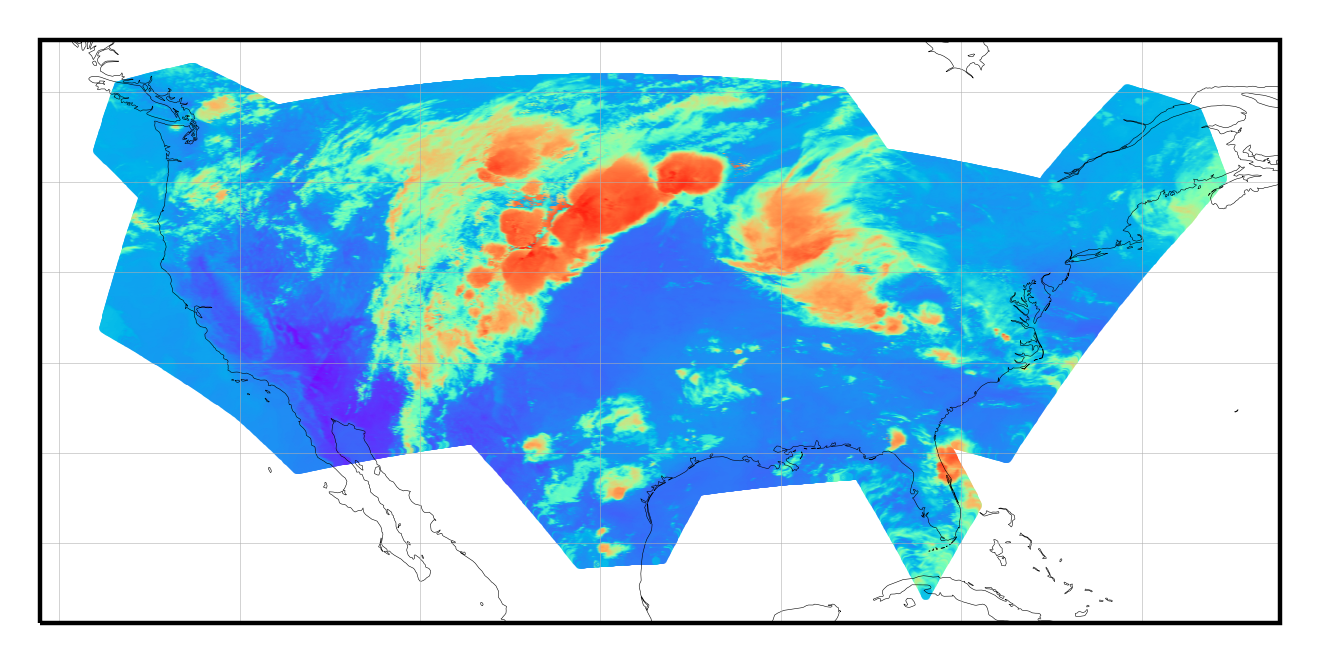

In [16]:
fig, ax = plt.subplots(figsize=(4,4), dpi=400
                       ,subplot_kw=plot_options
                      )
ax.gridlines(linewidth=0.1)
# ax.set_global()
ax.coastlines(linewidth=0.1)
# ax.grid(True)
if False:
    # x0 = 166; y0 = -15; dlim = 0.5
    # x0 = 165.5; y0 = -17.5; dlim = 3.75
    # dlimx = dlim; dlimy = dlim
    x0 = -127; y0 = 24; dlimx = 61; dlimy = 27
    
    ax.set_xlim(x0,x0+dlimx)
    ax.set_ylim(y0,y0+dlimy)

    marker_size=40.0/(dlim**2) # good for 'o'
    marker_size=27.0/(dlim**2) # good for 's'
    marker_alpha=0.5
else:
    ax.set_aspect('equal')
    marker_size=0.05
    marker_alpha=0.5
    
marker='s'

# jdf1.plot(ax=ax,column='map_data/BT_12.0m',zorder=1,cmap='OrRd',trixels=True)
# jdf1.plot(ax=ax,zorder=1,color='red',trixels=False,boundary=True)

ax.scatter(composite_subset['lons']
           ,composite_subset['lats']
           ,s=marker_size
           ,c=composite_subset['BT_12_0um']
           ,alpha=marker_alpha
#            ,cmap='nipy_spectral'
           ,cmap='rainbow_r'
           ,marker=marker
           ,rasterized=True
           ,transform=ccrs.PlateCarree()
                               )
# plt.scatter(jdf1['lons'],jdf1['lats'],s=marker_size,color='k',alpha=marker_alpha)
# plt.scatter(jdf1['lons'],jdf1['lats'],s=marker_size,color='k',alpha=marker_alpha)

# roi.plot(ax=ax, trixels=True, boundary=True, color='k', zorder=1, linewidth=0.5)
# conus1.plot(ax=ax, trixels=False, facecolor="none", edgecolor='yellow', zorder=1, linewidth=1.5)
    
del fig,ax

print('time to start plot: ',datetime.datetime.now() - start0)

In [17]:
print('time from plot start to render end: ',datetime.datetime.now() - start0)

time from plot start to render end:  0:00:17.053893


In [18]:
start0 = datetime.datetime.now()

In [19]:
composite_sorted = composite.sort_values('sids')
# composite_sorted

In [20]:
composite_sorted.to_hdf('composite.h5','stare_sorted',format='fixed',data_columns=['sids','BT_12_0um','lats','lons'])

In [21]:
print('time to save data in stare-sorted format, but no pods-index: ',datetime.datetime.now() - start0)

time to save data in stare-sorted format, but no pods-index:  0:00:30.044481


In [22]:
# !rm composite.h5

In [23]:
# !open composite.h5

In [24]:
# df = pandas.read_hdf('composite.h5',key='stare_sorted',mode='r',start=32481502,stop=32494822)

In [25]:
# df['sids']

In [26]:
# type(df)

In [27]:
def hex16(i):
    return "0x%016x"%i

In [28]:
level = 5
level_increment = pystare.spatial_increment_from_level(level)

nsids_at_level = (8 * (4**level))
sids_at_level = numpy.zeros([nsids_at_level],dtype=numpy.int64)

k = 0
# Plot each increment (overlay on common axes)
for siv_idx, siv in enumerate(range(0, nsids_at_level*level_increment, level_increment)):
    siv = siv + level # Set the level
    sids_at_level[k] = siv
    # print(k,siv,hex16(siv))
    k += 1

In [29]:
def binary_find(s,a):
    n=len(a)
    c=int(n/2)
    d=int(n/2)
    while d>0:
        # print(s,c,d,a.iloc[c])
        d = int(d/2)
        if s > a.iloc[c]:
            c += d
        elif s < a.iloc[c]:
            c -= d
        else:
            d=0
    return c-1

In [30]:
class chunk_lite:
    def __init__(self,start,stop):
        self.start = start
        self.stop  = stop
        return
    
pods_lite = {}
pods_lite_level = level

In [31]:
stare_bounds = {}
    
for k in range(0,nsids_at_level):
    start = binary_find(sids_at_level[k],composite_sorted['sids'])
    stop  = binary_find(pystare.spatial_terminator(sids_at_level[k]),composite_sorted['sids'])
    if start != stop:
        pods_lite[sids_at_level[k]] = chunk_lite(start,stop)

if False:
    for k in pods_lite.keys():
        print(hex16(k),pods_lite[k].start,pods_lite[k].stop)
    

In [32]:
keys = list(pods_lite.keys())
print('len keys: ',len(keys))

len keys:  8192


In [33]:
print('total time to save data in stare-sorted format and construct pods-index: ',datetime.datetime.now() - start0)

total time to save data in stare-sorted format and construct pods-index:  0:00:36.730223


In [34]:
plot_options = {'projection': ccrs.PlateCarree(central_longitude=0.0)
                ,'transform': ccrs.Geodetic()}

In [35]:
# take the intersection, get the level, coerce to it, then uniquify, then loop, load, and concat.
def read_hdf(filename,sids,pods_lite):
    resolution = int(pystare.spatial_resolution(list(pods_lite.keys())[0]))
    
    idx = numpy.unique(
        pystare.spatial_clear_to_resolution(
            pystare.spatial_coerce_resolution(pystare.expand_intervals(sids,resolution),resolution)))
                                              
    # print(idx)
    dfs = []
    for s in idx:
        chunk = pods_lite[s]
        df = pandas.read_hdf('composite.h5',start=chunk.start+2,stop=chunk.stop)
        dfs.append(df)
        
    return pandas.concat(dfs)

time to open/read and subset data from stare-sorted format:  0:00:08.327083
time to read data and start plot:  0:00:08.525247


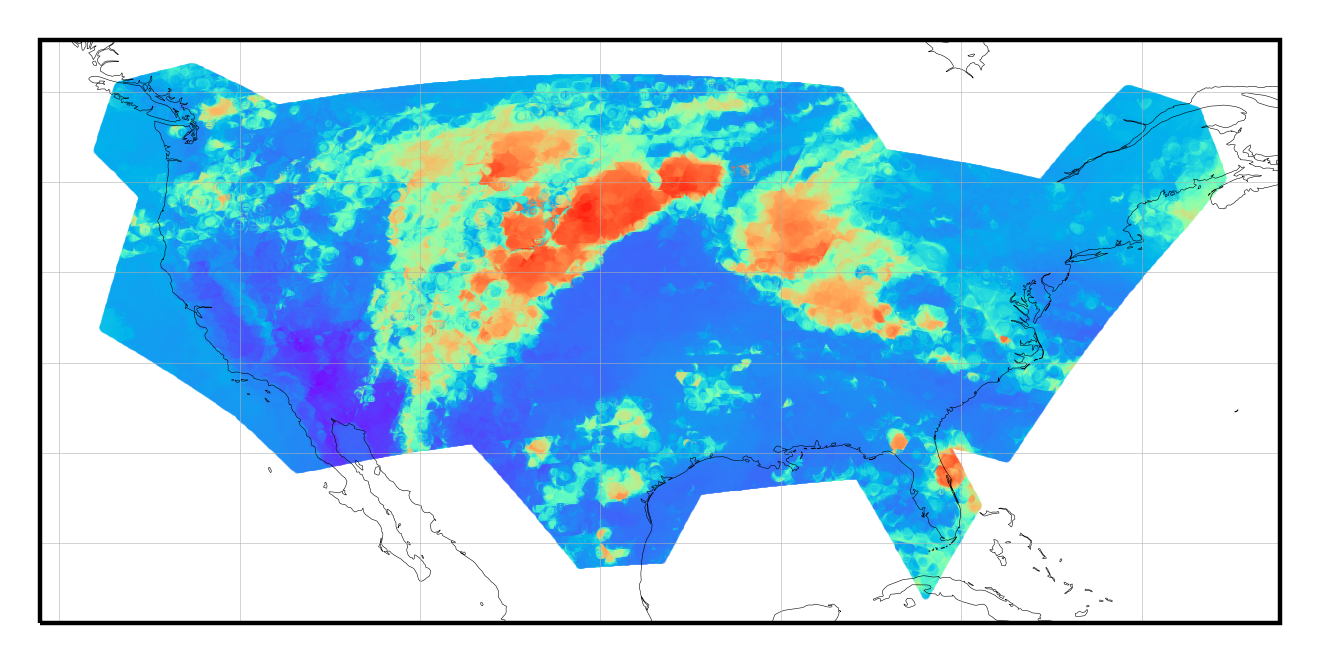

In [36]:
start0 = datetime.datetime.now()

# i = 90
# chunk = pods_lite[keys[i]]
# df = pandas.read_hdf('composite.h5',start=chunk.start+2,stop=chunk.stop)

# bdf = states[states.NAME=='Hawaii']
# b = states[states.NAME=='Hawaii']['sids'].iloc[0]

b = roi['sids'].iloc[:].to_numpy()

df = starepandas.STAREDataFrame(read_hdf('composite.h5',b,pods_lite)).reset_index()
c = df.stare_intersects(b,n_workers=50)
df = df[c]

print('time to open/read and subset data from stare-sorted format: ',datetime.datetime.now() - start0)

fig, ax = plt.subplots(figsize=(4,4), dpi=400
                        ,subplot_kw=plot_options
                      )
ax.gridlines(linewidth=0.1)
# ax.set_global()
ax.coastlines(linewidth=0.1)

if False:
    # x0 = 166; y0 = -15; dlim = 0.5
    # x0 = 165.5; y0 = -17.5; dlim = 3.75
    # dlimx = dlim; dlimy = dlim
    x0 = -127; y0 = 24; dlimx = 61; dlimy = 27
    
    ax.set_xlim(x0,x0+dlimx)
    ax.set_ylim(y0,y0+dlimy)

    marker_size=40.0/(dlim**2) # good for 'o'
    marker_size=27.0/(dlim**2) # good for 's'
    marker_alpha=0.5
else:
    ax.set_aspect('equal')
    marker_size=0.01
    marker_alpha=0.5
    
marker='s'

# df.plot(ax=ax,column='map_data/BT_12.0m',zorder=1,cmap='OrRd',trixels=True)
# df.plot(ax=ax,zorder=1,color='red',trixels=False,boundary=True)

# Doesn't work for 1-D data
# ax.contourf(df['lons'],df['lats'],df['BT_12_0um']
#            ,cmap='nipy_spectral'
#            ,cmap='rainbow'
#            ,transform=ccrs.PlateCarree()
#        )
if True:
    ax.scatter(df['lons'],df['lats']
                ,s=marker_size
                ,c=df['BT_12_0um']
                ,alpha=marker_alpha
    #            ,cmap='nipy_spectral'
                ,cmap='rainbow_r'
                ,marker=marker
                ,rasterized=True
                ,transform=ccrs.PlateCarree()
                )
# plt.scatter(df['lons'],jdf1['lats'],s=marker_size,color='k',alpha=marker_alpha)
# plt.scatter(df['lons'],jdf1['lats'],s=marker_size,color='k',alpha=marker_alpha)

if False:
    # bdf.plot(ax=ax, trixels=True, boundary=True, color='k', zorder=1, linewidth=0.25)
    roi.plot(ax=ax, trixels=True, boundary=True, color='k', zorder=1, linewidth=0.5)
    
if False:
    conus1.plot(ax=ax, trixels=False, facecolor="none", edgecolor='yellow', zorder=1, linewidth=1.5)
    
del fig,ax

print('time to read data and start plot: ',datetime.datetime.now()-start0)

In [37]:
print('total time to read & render: ',datetime.datetime.now() - start0)

total time to read & render:  0:00:20.371096


In [38]:
start0 = datetime.datetime.now()

In [39]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
# world.plot()

In [40]:
conus_boundary = world[world['name'] == 'United States of America'].clip(
    Polygon([(-125,24.5),(-66,24.5),(-66,49.5),(-125,49.5)])
).boundary

In [41]:
print('time to construct boundary for subsetting: ',datetime.datetime.now() - start0)

time to construct boundary for subsetting:  0:00:00.075382


In [42]:
# conus_boundary.plot()

In [43]:
start0 = datetime.datetime.now()

In [44]:
with xarray.open_dataset('ignored/satCORPS/composite_20220420_2019.182.0230.nc'
                         ,engine='netcdf4'
                         ,group='map_data'
                         ,decode_times=False
                        ) as file_nc:
     composite_file_nc = file_nc

In [45]:
print('time to open/read data: ',datetime.datetime.now() - start0)

time to open/read data:  0:00:00.087074


In [46]:
lons = composite_file_nc.lon[:]
lats = composite_file_nc.lat[:]
lon, lat = numpy.meshgrid(lons, lats)

In [47]:
my_regions = regionmask.Regions(conus_boundary)
mask = my_regions.mask(lon,lat)

/Users/mrilee/opt/anaconda3/envs/pystare-dev-1/lib/python3.10/site-packages/regionmask/core/regions.py:108: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  regions[n] = _OneRegion(n, names[n], abbrevs[n], outlines[n])


In [48]:
print('total time to make mask: ',datetime.datetime.now() - start0)

total time to make mask:  0:00:30.649772


In [49]:
start0 = datetime.datetime.now()

In [50]:
with xarray.load_dataset('ignored/satCORPS/composite_20220420_2019.182.0230.nc'
                         ,engine='netcdf4'
                         ,group='map_data'
                         ,decode_times=False
                        ) as file_nc:
     composite_file_nc = file_nc
print('time to open/read data: ',datetime.datetime.now() - start0)

time to open/read data:  0:00:32.662711


In [51]:
BT12um_masked=composite_file_nc['BT_12.0um'].where(~numpy.isnan(mask.data))

In [52]:
print('time to read and mask data: ',datetime.datetime.now() - start0)

time to read and mask data:  0:00:32.866620


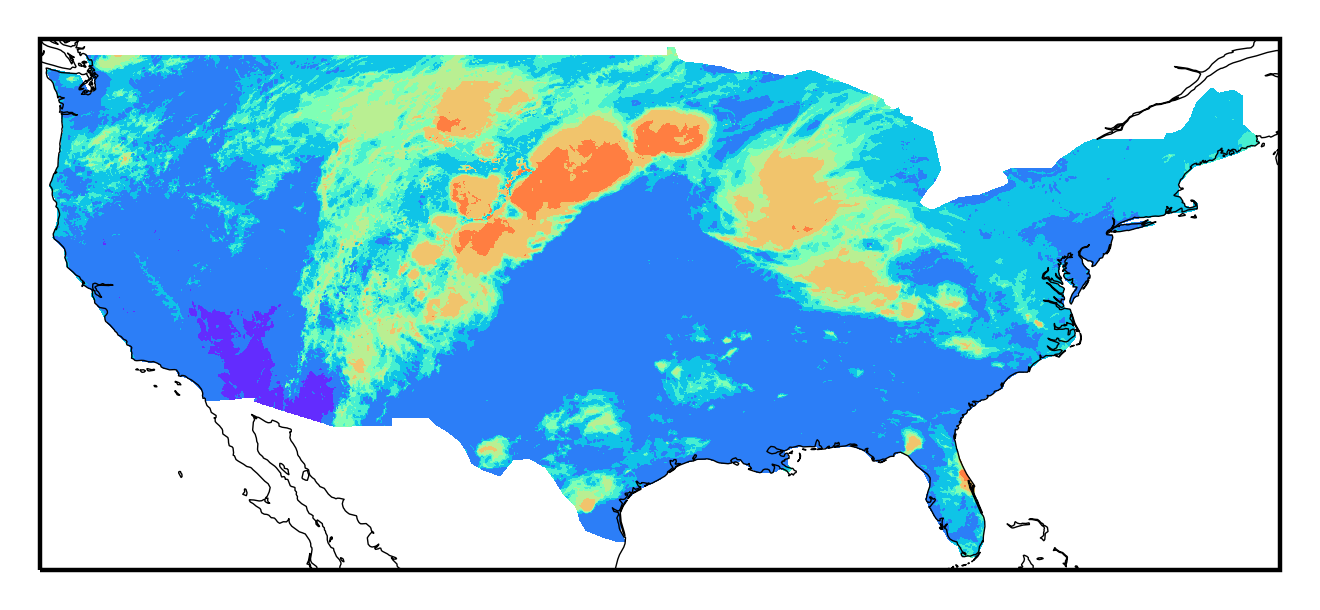

time to start contourf:  0:00:18.196573


In [53]:
start0 = datetime.datetime.now()

fig, ax = plt.subplots(figsize=(4,4), dpi=400
                        ,subplot_kw=plot_options
                      )
# ax.set_global()
ax.set_xlim(-125,-66)
ax.set_ylim(24.5,49.75)

# BT12um_masked.plot(ax=ax,transform=ccrs.PlateCarree())
ax.contourf(lon,lat,BT12um_masked,transform=ccrs.PlateCarree(),cmap='rainbow_r')

ax.coastlines(linewidth=0.25)

plt.show()
del fig,ax

print('time to start contourf: ',datetime.datetime.now() - start0)

In [54]:
print('total time to contourf: ',datetime.datetime.now() - start0)

total time to contourf:  0:00:18.204700


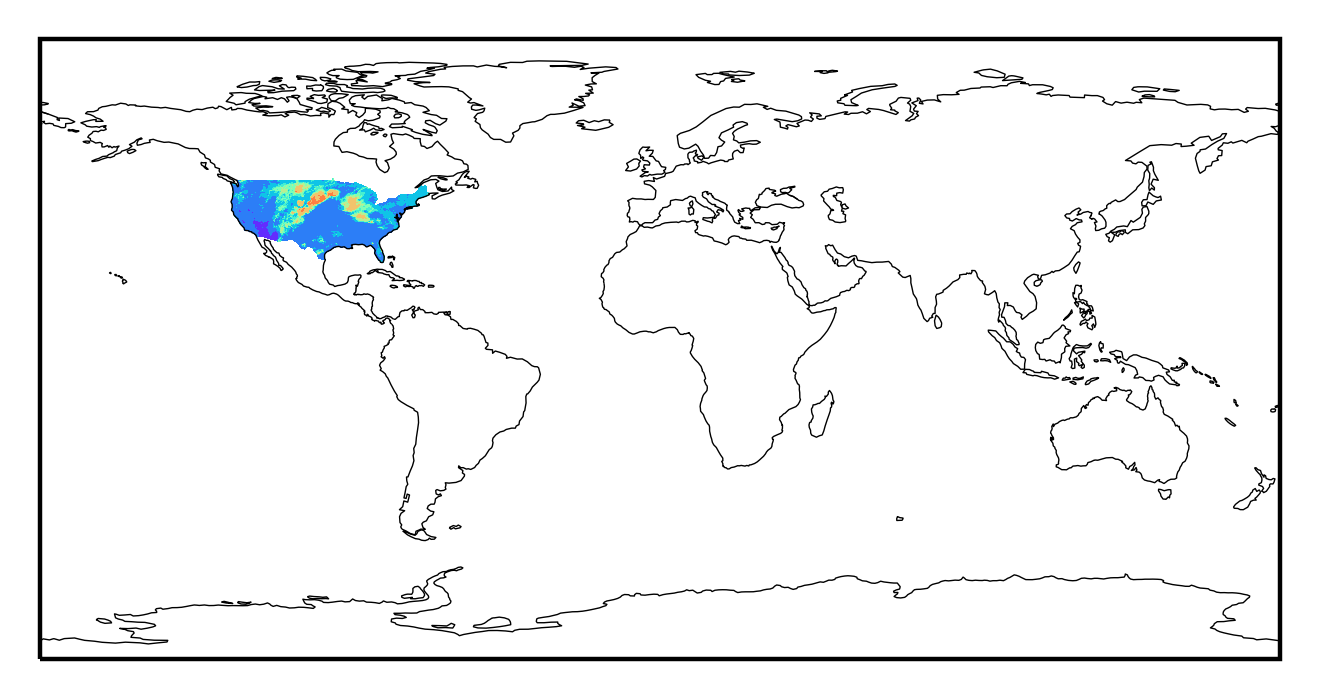

time to start contourf:  0:00:35.589109


In [55]:
fig, ax = plt.subplots(figsize=(4,4), dpi=400
                        ,subplot_kw=plot_options
                      )
# ax.set_global()

# BT12um_masked.plot(ax=ax,transform=ccrs.PlateCarree())
ax.contourf(lon,lat,BT12um_masked,transform=ccrs.PlateCarree(),cmap='rainbow_r')

ax.coastlines(linewidth=0.25)

plt.show()
del fig,ax

print('time to start contourf: ',datetime.datetime.now() - start0)

In [56]:
print('total time to contourf: ',datetime.datetime.now() - start0)

total time to contourf:  0:00:35.595867


time to start scatter plot:  0:00:12.907922


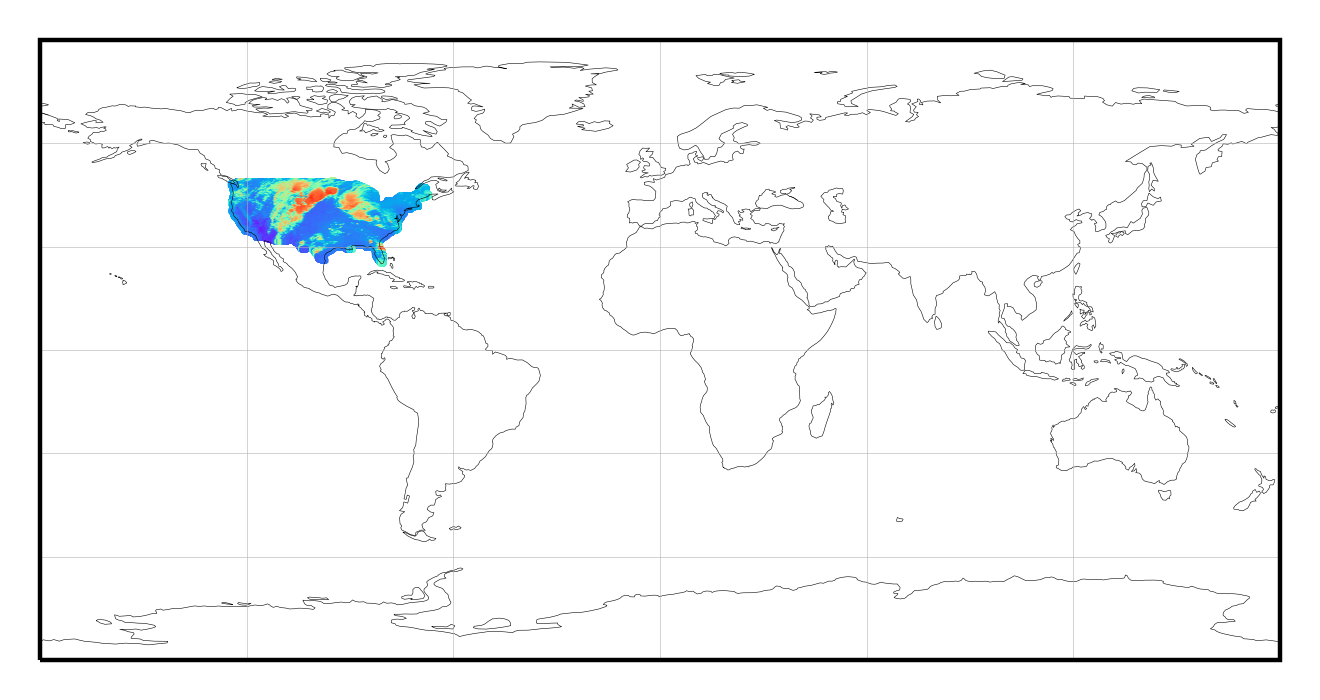

In [57]:
start0 = datetime.datetime.now()

fig, ax = plt.subplots(figsize=(4,4), dpi=400
                        ,subplot_kw=plot_options
                      )
ax.gridlines(linewidth=0.1)
# ax.set_global()
ax.coastlines(linewidth=0.1)

if False:
    # x0 = 166; y0 = -15; dlim = 0.5
    # x0 = 165.5; y0 = -17.5; dlim = 3.75
    # dlimx = dlim; dlimy = dlim
    x0 = -127; y0 = 24; dlimx = 61; dlimy = 27
    
    ax.set_xlim(x0,x0+dlimx)
    ax.set_ylim(y0,y0+dlimy)

    marker_size=40.0/(dlim**2) # good for 'o'
    marker_size=27.0/(dlim**2) # good for 's'
    marker_alpha=0.5
else:
    ax.set_aspect('equal')
    marker_size=0.01
    marker_alpha=0.5
    
marker='s'

# df.plot(ax=ax,column='map_data/BT_12.0m',zorder=1,cmap='OrRd',trixels=True)
# df.plot(ax=ax,zorder=1,color='red',trixels=False,boundary=True)

ax.scatter(lon,lat
            ,s=marker_size
            ,c=BT12um_masked.data
            ,alpha=marker_alpha
#            ,cmap='nipy_spectral'
            ,cmap='rainbow_r'
            ,marker=marker
            ,rasterized=True
            ,transform=ccrs.PlateCarree()
            )
# plt.scatter(df['lons'],jdf1['lats'],s=marker_size,color='k',alpha=marker_alpha)
# plt.scatter(df['lons'],jdf1['lats'],s=marker_size,color='k',alpha=marker_alpha)

if False:
    # bdf.plot(ax=ax, trixels=True, boundary=True, color='k', zorder=1, linewidth=0.25)
    roi.plot(ax=ax, trixels=True, boundary=True, color='k', zorder=1, linewidth=0.5)
    
if False:
    conus1.plot(ax=ax, trixels=False, facecolor="none", edgecolor='yellow', zorder=1, linewidth=1.5)
    
del fig,ax

print('time to start scatter plot: ',datetime.datetime.now()-start0)

In [58]:
print('total time to render scatter plot: ',datetime.datetime.now()-start0)

total time to render scatter plot:  0:10:41.971544


time to start scatter plot:  0:00:00.036485


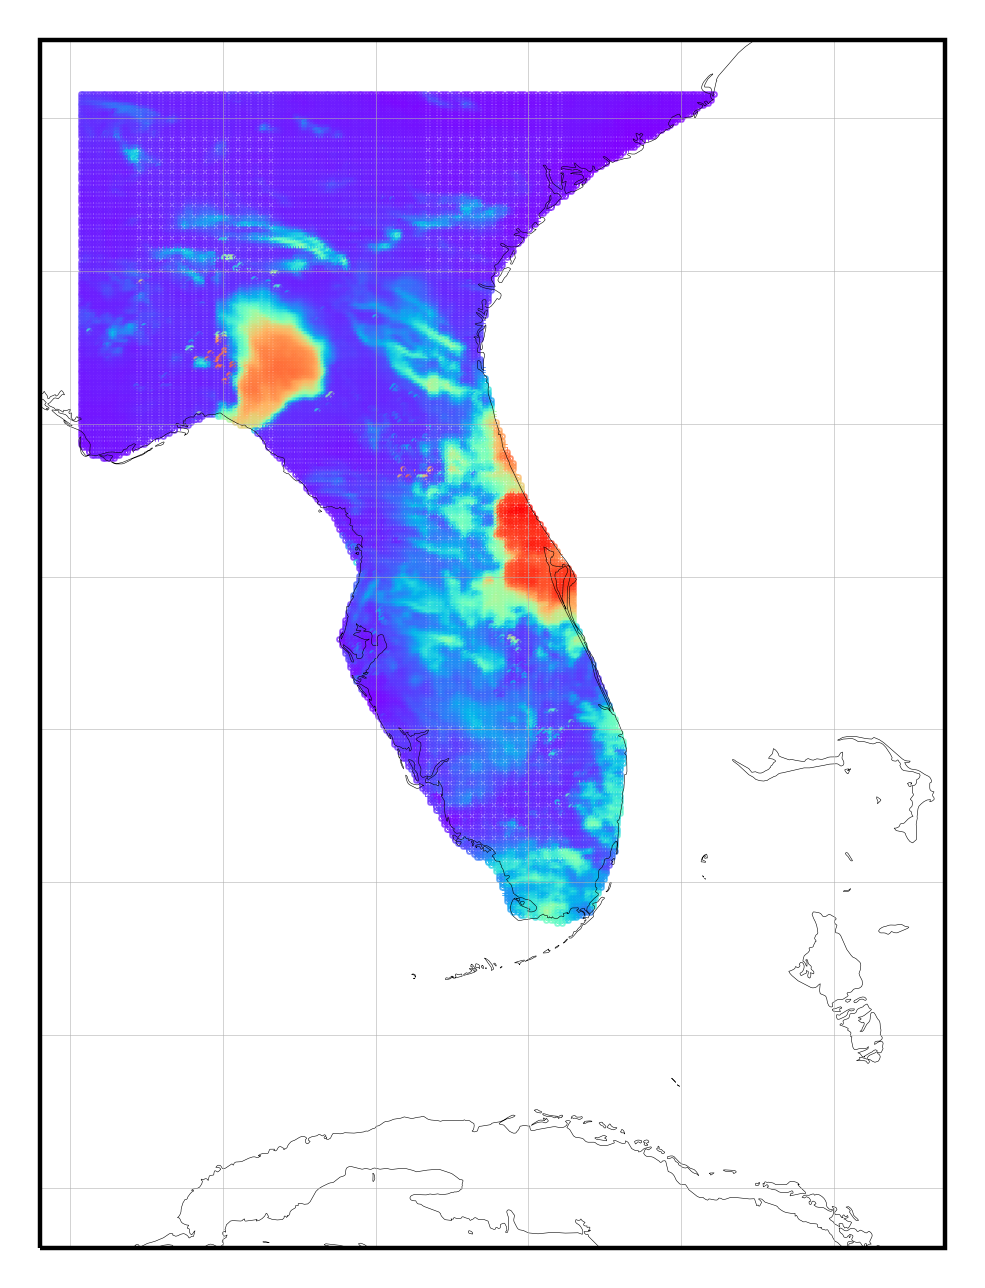

In [120]:
start0 = datetime.datetime.now()

fig, ax = plt.subplots(figsize=(4,4), dpi=400
                        ,subplot_kw=plot_options
                      )
ax.gridlines(linewidth=0.1)
# ax.set_global()
ax.coastlines(linewidth=0.1)

if False:
    # x0 = 166; y0 = -15; dlim = 0.5
    # x0 = 165.5; y0 = -17.5; dlim = 3.75
    # dlimx = dlim; dlimy = dlim
    x0 = -127; y0 = 24; dlimx = 61; dlimy = 27; dlim=dlimy
    
    ax.set_xlim(x0,x0+dlimx)
    ax.set_ylim(y0,y0+dlimy)

    marker_scale=0.05
    marker_size=marker_scale*40.0/(dlim**2) # good for 'o'
    marker_size=marker_scale*27.0/(dlim**2) # good for 's'
    marker_alpha=1
else:
    ax.set_aspect('equal')
    marker_size=0.025
    marker_alpha=0.75
    
marker='s'

# df.plot(ax=ax,column='map_data/BT_12.0m',zorder=1,cmap='OrRd',trixels=True)
# df.plot(ax=ax,zorder=1,color='red',trixels=False,boundary=True)


if True:
    if False:
        idx=numpy.random.randint(0,high=6600,size=200000)
        idy=numpy.random.randint(0,high=13320,size=200000)

        ax.scatter(lon[idx,idy],lat[idx,idy]
                    ,s=marker_size
                    ,c=BT12um_masked.data[idx,idy]
                    ,alpha=marker_alpha
        #            ,cmap='nipy_spectral'
                    ,cmap='rainbow_r'
                    ,marker=marker
                    ,rasterized=True
                    ,transform=ccrs.PlateCarree()
                    )
    
    if True:
        x0 = 3500
        x1 = 3800
        y0 = 2100
        y1 = 2500

        ax.scatter(lon[y0:y1,x0:x1],lat[y0:y1,x0:x1]
                ,s=marker_size
                ,c=BT12um_masked.data[y0:y1,x0:x1]
                ,alpha=marker_alpha
    #            ,cmap='nipy_spectral'
                ,cmap='rainbow_r'
                ,marker=marker
                ,rasterized=True
                ,transform=ccrs.PlateCarree()
                )
else:
    ax.scatter(lon,lat
                ,s=marker_size
                ,c=BT12um_masked.data
                ,alpha=marker_alpha
    #            ,cmap='nipy_spectral'
                ,cmap='rainbow_r'
                ,marker=marker
                ,rasterized=True
                ,transform=ccrs.PlateCarree()
                )


# plt.scatter(df['lons'],jdf1['lats'],s=marker_size,color='k',alpha=marker_alpha)
# plt.scatter(df['lons'],jdf1['lats'],s=marker_size,color='k',alpha=marker_alpha)

if False:
    # bdf.plot(ax=ax, trixels=True, boundary=True, color='k', zorder=1, linewidth=0.25)
    roi.plot(ax=ax, trixels=True, boundary=True, color='k', zorder=1, linewidth=0.5)
    
if False:
    conus1.plot(ax=ax, trixels=False, facecolor="none", edgecolor='yellow', zorder=1, linewidth=1.5)
    
del fig,ax

print('time to start scatter plot: ',datetime.datetime.now()-start0)

In [60]:
print('total time to render scatter plot: ',datetime.datetime.now()-start0)

total time to render scatter plot:  0:00:00.734576


In [74]:
BT12um_masked.data.shape

(6660, 13320)